In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive



# Twitter Sentiment Analysis

The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

**Load the required libraries**

In [2]:
import pandas as pd #To load the data
import matplotlib.pyplot as plt
import seaborn as sns
import re #To remove the unwanted words
import nltk 
from nltk.corpus import stopwords #To remove the stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from keras.models import Sequential
from keras.layers import Conv1D,Embedding,Dense,MaxPool1D,LSTM,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


**Load the Data**

In [3]:
data = pd.read_csv('/content/drive/My Drive/Twitter Analysis/train.csv') #Load the data
data.drop(['id'],inplace = True,axis = 1) # Remove the column 'id' which is not usefull for predicting the label
data.head() 

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


**Exploratory data analysis(EDA)**

In [0]:
# function to collect hashtags
def HashTags(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

**HashTags for Negative Tweets**

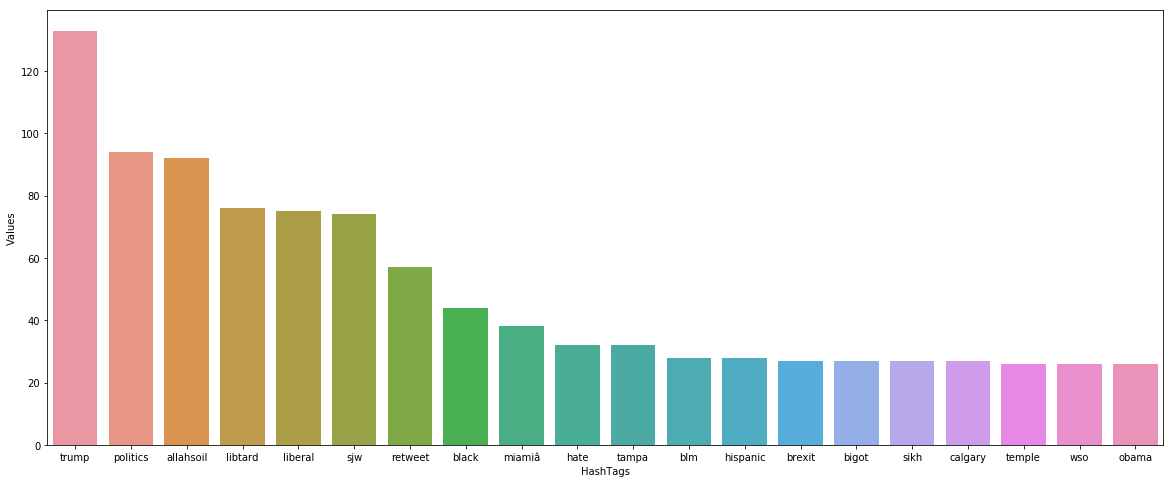

In [5]:
neg_hashtags = HashTags(data['tweet'][data['label'] == 1])
freq = nltk.FreqDist(sum(neg_hashtags,[]))#Unnesting the list
hashtags = pd.DataFrame({'HashTags' : list(freq.keys()),'Values' : list(freq.values())})
# selecting top 20 most frequent hashtags     
hashtags = hashtags.nlargest(columns="Values", n = 20) 
plt.figure(figsize=(20,8))
sns.barplot(data=hashtags, x= "HashTags", y = "Values")

**HashTags for Positive Tweets**

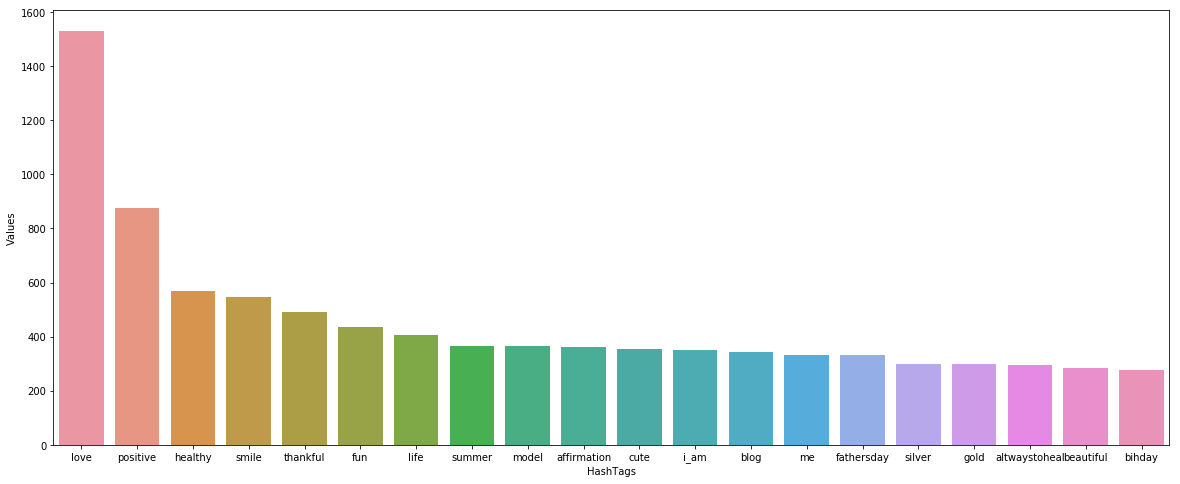

In [6]:
pos_hashtags = HashTags(data['tweet'][data['label'] == 0])
freq = nltk.FreqDist(sum(pos_hashtags,[]))#Unnesting the list
hashtags = pd.DataFrame({'HashTags' : list(freq.keys()),'Values' : list(freq.values())})
# selecting top 20 most frequent hashtags     
hashtags = hashtags.nlargest(columns="Values", n = 20) 
plt.figure(figsize=(20,8))
sns.barplot(data=hashtags, x= "HashTags", y = "Values")

**WordCloud**

In [0]:
def wc(data,i):
  tweets = " ".join(data['tweet'][data['label'] == i ])
  tweets = re.sub(r'@\w+','',tweets)#Remove the user names that starts with '@'
  tweets = ' '.join([word.lower() for word in nltk.word_tokenize(tweets)])
  tweets = re.sub(r'[^a-zA-Z]',' ',tweets)#Remove numbers,puncutions
  tweets = " ".join(tweets.split())#to remove the spaces 
  tokens = nltk.word_tokenize(tweets)# Tokenize the Sentences
  tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stop and len(word) > 2]
  return nltk.FreqDist(tokens)

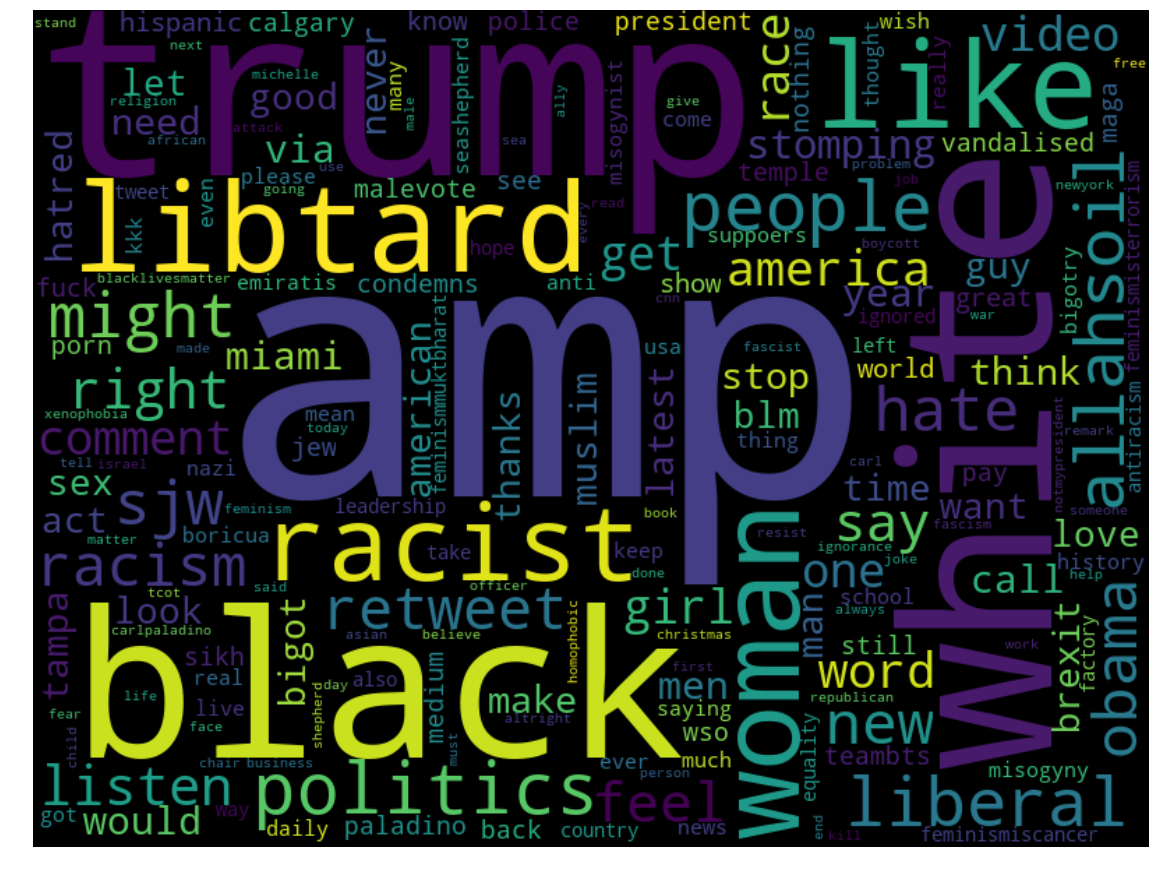

In [8]:
text = wc(data,1)
neg_wordcloud = WordCloud(width = 800 , height = 600,random_state=21).generate_from_frequencies(text)
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(neg_wordcloud,interpolation = 'bilinear')
plt.show()

**Negative WordCloud Inferences :**

Most of the tweets are related to

1.)Religious Tweets

2.)Politics

3.)Racist Tweets

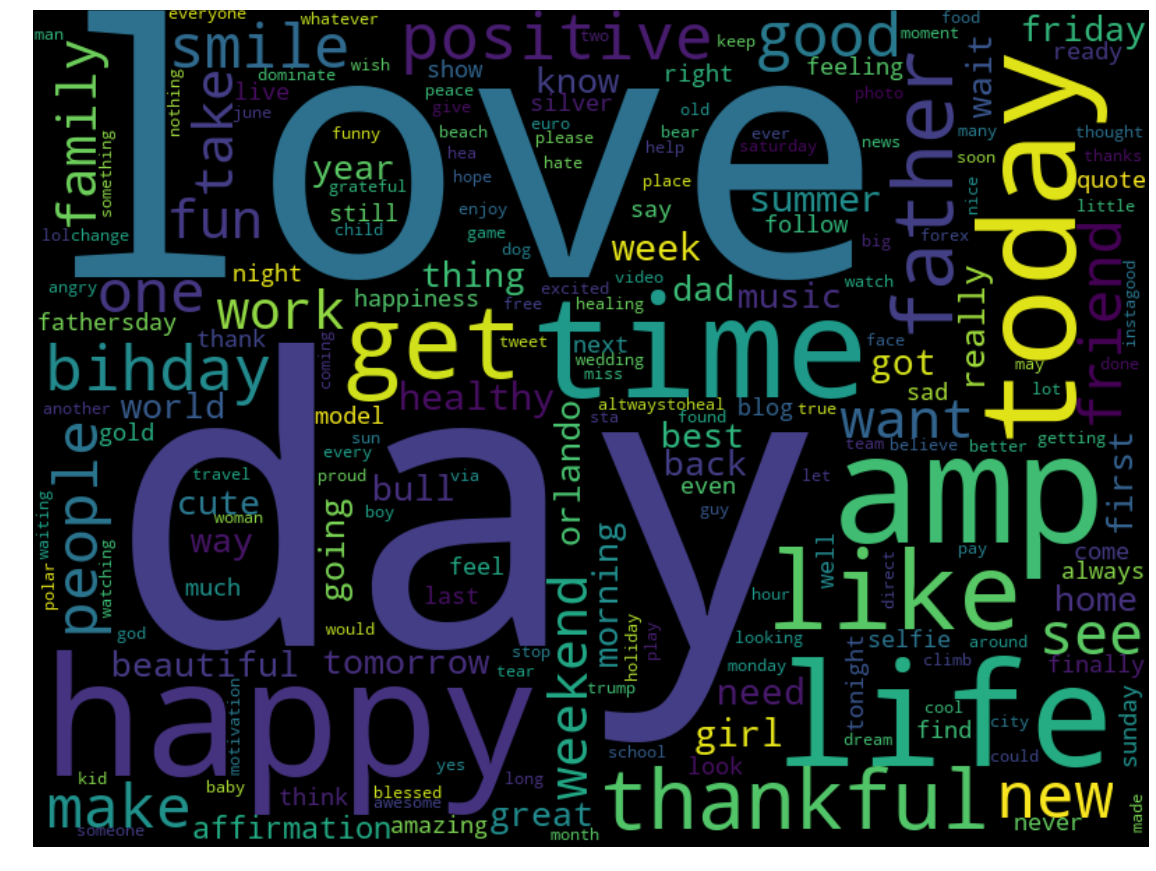

In [9]:
from wordcloud import WordCloud
text = wc(data,0)
neg_wordcloud = WordCloud(width = 800 , height = 600,random_state=21).generate_from_frequencies(text)
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(neg_wordcloud,interpolation = 'bilinear')
plt.show()

**Positive WordCloud Inferences:**

All the Words are positive(love,happy,like,thankful,great ect) in Positive WordCloud 


**Data Preprocessing**

In [10]:
data['preprocess'] = data['tweet'].str.replace("@[\w]*", "")
data['preprocess'] = data['preprocess'].str.replace("[^a-zA-Z#]", " ")
data['preprocess'] = data['preprocess'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tokenized_tweet = data['preprocess'].apply(lambda x: x.split()) # tokenizing
tokenized_tweet = tokenized_tweet.apply(lambda x: [WordNetLemmatizer().lemmatize(i) for i in x if i not in stop and len(i) > 2]) # stemming
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
data['preprocess'] = tokenized_tweet
data.head()

,label,tweet,preprocess
0,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause offer wheelchair van...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,#model love take time
4,0,factsguide: society now #motivation,factsguide society #motivation


**Split the data into train and test**

In [58]:
from sklearn.model_selection import train_test_split #Split the data into train and test
X_train,X_test,Y_train,Y_test = train_test_split(data['preprocess'].values,data['label'].values,random_state = 42,stratify = data['label'],test_size = 0.3)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((22373,), (9589,), (22373,), (9589,))

**Bag of Words**

In [21]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(X_train)
bow.shape

(22373, 1000)

**Term Frequency Inverse Document Frequency(TFIDF)**

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(X_train)
tfidf.shape

(22373, 1000)

**We will Create a custom function to see which model is predicting better**

In [0]:
def Model(model,Input,Output,TestInput,TestOutput):
  clf = model
  clf.fit(Input,Output)
  test_prediction = clf.predict(TestInput)
  print(metrics.classification_report(y_true = TestOutput,y_pred = test_prediction))
  sns.heatmap(metrics.confusion_matrix(y_true = TestOutput,y_pred = test_prediction),fmt ='d',annot = True)

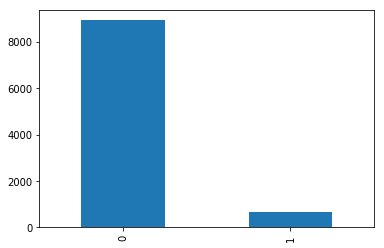

In [24]:
pd.Series(Y_test).value_counts().plot(kind = 'bar')

If you see the bar plot the count of negative tweets are less

**Build the model on Bag of Words and TFIDF**

1. Logistic Regression on Bag of Words

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8916
           1       0.79      0.34      0.48       673

    accuracy                           0.95      9589
   macro avg       0.87      0.67      0.72      9589
weighted avg       0.94      0.95      0.94      9589



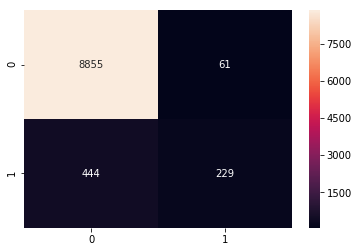

In [36]:
Model(LogisticRegression(),bow,Y_train,bow_vectorizer.transform(X_test),Y_test)

2. Logistic Regression on TFIDF

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8916
           1       0.82      0.30      0.44       673

    accuracy                           0.95      9589
   macro avg       0.88      0.65      0.71      9589
weighted avg       0.94      0.95      0.93      9589



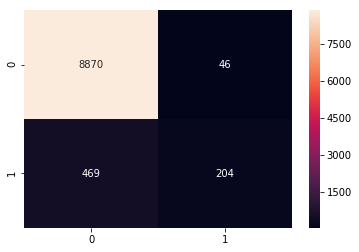

In [37]:
Model(LogisticRegression(),tfidf,Y_train,tfidf_vectorizer.transform(X_test),Y_test)

3. Decision Tree on Bag of words

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8916
           1       0.53      0.51      0.52       673

    accuracy                           0.93      9589
   macro avg       0.75      0.74      0.74      9589
weighted avg       0.93      0.93      0.93      9589



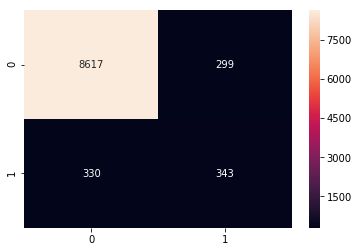

In [38]:
Model(DecisionTreeClassifier(),bow,Y_train,bow_vectorizer.transform(X_test),Y_test)

4. Decision Tree on TFIDF

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8916
           1       0.65      0.47      0.54       673

    accuracy                           0.94      9589
   macro avg       0.81      0.72      0.76      9589
weighted avg       0.94      0.94      0.94      9589



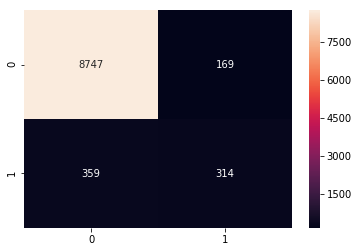

In [39]:
Model(DecisionTreeClassifier(),tfidf,Y_train,tfidf_vectorizer.transform(X_test),Y_test)

5. Gradient Boosting on Bag of Words

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8916
           1       0.86      0.27      0.41       673

    accuracy                           0.95      9589
   macro avg       0.90      0.63      0.69      9589
weighted avg       0.94      0.95      0.93      9589



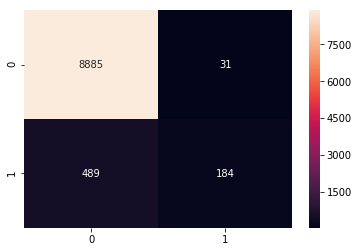

In [40]:
Model(GradientBoostingClassifier(),bow,Y_train,bow_vectorizer.transform(X_test),Y_test)

6. Gradient Boosting on TFIDF

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8916
           1       0.86      0.27      0.42       673

    accuracy                           0.95      9589
   macro avg       0.90      0.64      0.69      9589
weighted avg       0.94      0.95      0.93      9589



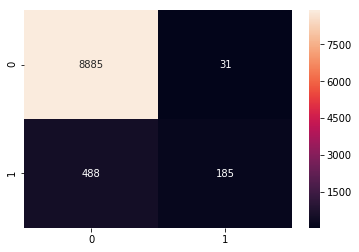

In [41]:
Model(GradientBoostingClassifier(),tfidf,Y_train,tfidf_vectorizer.transform(X_test),Y_test)

7. Random Forest on Bag of Words

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8916
           1       0.59      0.51      0.55       673

    accuracy                           0.94      9589
   macro avg       0.78      0.74      0.76      9589
weighted avg       0.94      0.94      0.94      9589



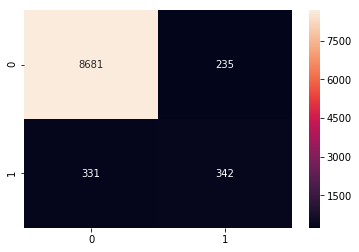

In [42]:
Model(RandomForestClassifier(),bow,Y_train,bow_vectorizer.transform(X_test),Y_test)

8. random Forest on TFIDF

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8916
           1       0.74      0.42      0.53       673

    accuracy                           0.95      9589
   macro avg       0.85      0.70      0.75      9589
weighted avg       0.94      0.95      0.94      9589



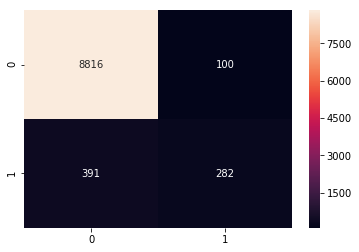

In [43]:
Model(RandomForestClassifier(),tfidf,Y_train,tfidf_vectorizer.transform(X_test),Y_test)

9. AdaBoost on Bag of Words

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8916
           1       0.71      0.35      0.47       673

    accuracy                           0.94      9589
   macro avg       0.83      0.67      0.72      9589
weighted avg       0.94      0.94      0.94      9589



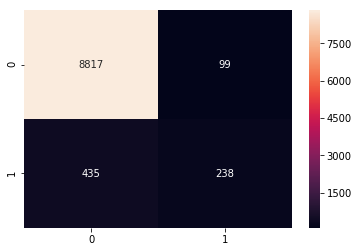

In [44]:
Model(AdaBoostClassifier(),bow,Y_train,bow_vectorizer.transform(X_test),Y_test)

10. AdaBoost on TFIDF

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      8916
           1       0.75      0.32      0.45       673

    accuracy                           0.94      9589
   macro avg       0.85      0.65      0.71      9589
weighted avg       0.94      0.94      0.93      9589



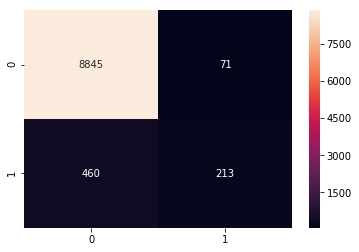

In [45]:
Model(AdaBoostClassifier(),tfidf,Y_train,tfidf_vectorizer.transform(X_test),Y_test)

**Inferences:**

1. Accuracy is good for all the models

2. Recall or Sensitivity is very low for Minority classes

3. All the models predicts well on Majority classes

Now We will build Deep Neural Network on Data

In [46]:
#Tokenize the data
tokenizer = Tokenizer(num_words = 20000, lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27811 unique tokens.


In [47]:
#to get the length of the largest review
lengths = []
for i in range(0,len(X_train)):
  lengths.append(len(X_train[i]))
max(lengths)  

130

In [48]:
X = tokenizer.texts_to_sequences(X_train)
X[0]

[2, 11, 597, 633, 6658, 5, 20, 4156, 12, 5098]

In [0]:
X = pad_sequences(X ,maxlen = 130)

In [50]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (22373, 130)


**Simple LSTM**

In [51]:
model = Sequential()
model.add(Embedding(20000,100,input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 100)          2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 130, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,080,501
Trainable params: 2,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
history = model.fit(X, Y_train , epochs=5, batch_size=32 ,validation_split=0.2)

Train on 17898 samples, validate on 4475 samples
Epoch 1/5
17898/17898 [==============================] - 186s 10ms/step - loss: 0.1864 - acc: 0.9431 - val_loss: 0.1211 - val_acc: 0.9593
Epoch 2/5
17898/17898 [==============================] - 182s 10ms/step - loss: 0.0762 - acc: 0.9740 - val_loss: 0.1206 - val_acc: 0.9604
Epoch 3/5
17898/17898 [==============================] - 182s 10ms/step - loss: 0.0390 - acc: 0.9868 - val_loss: 0.1371 - val_acc: 0.9607
Epoch 4/5
17898/17898 [==============================] - 180s 10ms/step - loss: 0.0230 - acc: 0.9918 - val_loss: 0.1740 - val_acc: 0.9600
Epoch 5/5
17898/17898 [==============================] - 182s 10ms/step - loss: 0.0156 - acc: 0.9952 - val_loss: 0.1870 - val_acc: 0.9569


Preprocess the test data to predict the labels

In [0]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test , maxlen = 130)
test_prediction = model.predict_classes(X_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8916
           1       0.72      0.61      0.66       673

    accuracy                           0.96      9589
   macro avg       0.85      0.80      0.82      9589
weighted avg       0.95      0.96      0.95      9589



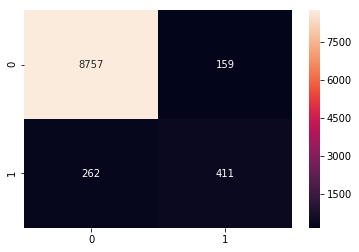

In [54]:
print(metrics.classification_report(Y_test,test_prediction))
sns.heatmap(metrics.confusion_matrix(Y_test,test_prediction),fmt ='d',annot = True)

If you see the Confusion Matrix Recall has been Improved compared to other models

**LSTM and Convolutional Neural Network**

In [55]:
model2 = Sequential()
model2.add(Embedding(20000,150,input_length = X.shape[1]))
model2.add(Dropout(0.2))
model2.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPool1D(pool_size = 2))
model2.add(LSTM(200,dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1,activation = 'sigmoid'))
model2.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics  = ['accuracy'])
print(model2.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 130, 150)          3000000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 130, 150)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 64)           28864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 3,241,065
Trainable params: 3,241,065
Non-trainable params: 0
___________________________________________

In [56]:
model2.fit(X,Y_train,epochs = 5 ,batch_size= 32 ,validation_split=0.2)

Train on 17898 samples, validate on 4475 samples
Epoch 1/5
17898/17898 [==============================] - 104s 6ms/step - loss: 0.1757 - acc: 0.9447 - val_loss: 0.1206 - val_acc: 0.9575
Epoch 2/5
17898/17898 [==============================] - 98s 5ms/step - loss: 0.0704 - acc: 0.9773 - val_loss: 0.1213 - val_acc: 0.9618
Epoch 3/5
17898/17898 [==============================] - 99s 6ms/step - loss: 0.0329 - acc: 0.9887 - val_loss: 0.1508 - val_acc: 0.9593
Epoch 4/5
17898/17898 [==============================] - 99s 6ms/step - loss: 0.0146 - acc: 0.9958 - val_loss: 0.1736 - val_acc: 0.9580
Epoch 5/5
17898/17898 [==============================] - 97s 5ms/step - loss: 0.0077 - acc: 0.9975 - val_loss: 0.2209 - val_acc: 0.9593


In [0]:
test_prediction2 = model2.predict_classes(X_test)

In [61]:
print(metrics.classification_report(Y_test,test_prediction2))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8916
           1       0.72      0.58      0.64       673

    accuracy                           0.95      9589
   macro avg       0.84      0.78      0.81      9589
weighted avg       0.95      0.95      0.95      9589



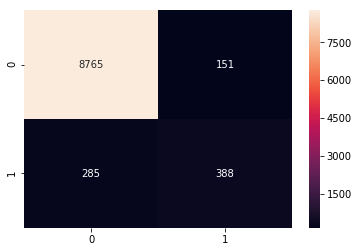

In [62]:
sns.heatmap(metrics.confusion_matrix(Y_test,test_prediction2),fmt ='d',annot = True)

**Inferences**

1. Accuracy for the Simple LSTM is good compared to (LSTM and Convolutional Neural Network)

2. Recall rate is also good for Simple LSTM

# Now build the Simple LSTM model on complete data

In [70]:
#Tokenize the data
tokenizer = Tokenizer(num_words = 20000, lower=True)
tokenizer.fit_on_texts(data['preprocess'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34925 unique tokens.


In [73]:
#to get the length of the largest review
lengths = []
for i in range(0,len(data['preprocess'].values)):
  lengths.append(len(data['preprocess'].values[i]))
max(lengths)  

130

In [71]:
X = tokenizer.texts_to_sequences(data['preprocess'].values)
X[0]

[10, 13195, 2219, 2987, 189, 6641, 735]

In [0]:
X = pad_sequences(X ,maxlen = 130)

In [74]:
X.shape

(31962, 130)

In [76]:
model.fit(X, data['label'].values , epochs=5, batch_size=32 )

Epoch 1/5
31962/31962 [==============================] - 292s 9ms/step - loss: 0.0399 - acc: 0.9883
Epoch 2/5
31962/31962 [==============================] - 298s 9ms/step - loss: 0.0212 - acc: 0.9937
Epoch 3/5
31962/31962 [==============================] - 299s 9ms/step - loss: 0.0132 - acc: 0.9959
Epoch 4/5
31962/31962 [==============================] - 295s 9ms/step - loss: 0.0091 - acc: 0.9967
Epoch 5/5
31962/31962 [==============================] - 297s 9ms/step - loss: 0.0062 - acc: 0.9979


# Predict the Test labels

In [77]:
test = pd.read_csv('/content/drive/My Drive/Twitter Analysis/test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


**Data Preprocessing on test data**

In [78]:
test['preprocess'] = test['tweet'].str.replace("@[\w]*", "")
test['preprocess'] = test['preprocess'].str.replace("[^a-zA-Z#]", " ")
test['preprocess'] = test['preprocess'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tokenized_tweet = test['preprocess'].apply(lambda x: x.split()) # tokenizing
tokenized_tweet = tokenized_tweet.apply(lambda x: [WordNetLemmatizer().lemmatize(i) for i in x if i not in stop and len(i) > 2]) # stemming
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
test['preprocess'] = tokenized_tweet
test.head()

,id,tweet,preprocess
0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...,#white #supremacists want everyone #birds #movie
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal #acne #altwaystoheal #healthy #h...
3,31966,is the hp and the cursed child book up for res...,cursed child book reservation already #harrypo...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",#bihday amazing hilarious #nephew ahmir uncle ...


In [79]:
test = tokenizer.texts_to_sequences(test['preprocess'].values)
test[0]

[11353, 7408, 1022, 6258, 80]

In [0]:
test = pad_sequences(test ,maxlen = 130)

In [0]:
label = model.predict_classes(test)